In [1]:
import sys
import os

# Ajouter le dossier parent au path
sys.path.append(os.path.abspath(os.path.join('..')))

# Ensuite tu peux importer ton module
import utils


In [3]:
df = utils.load_data("../../cleaned_data/joueurs_ligue1_2024_2025_clean_per90.csv")
df.shape

Error loading data: [Errno 2] No such file or directory: '../../cleaned_data/clean_joueurs_ligue1_2024_2025_clean_per90.csv'


AttributeError: 'NoneType' object has no attribute 'shape'

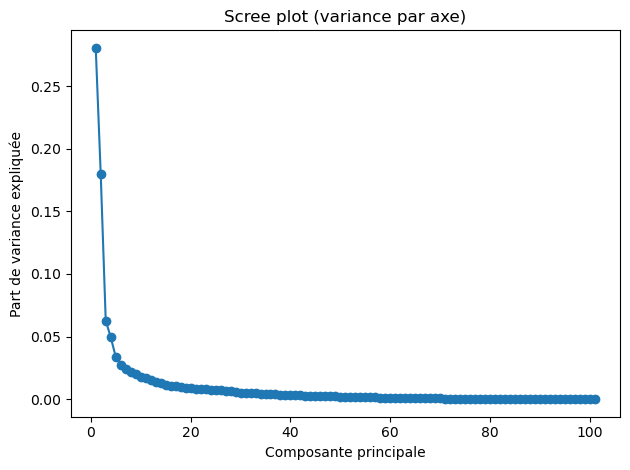

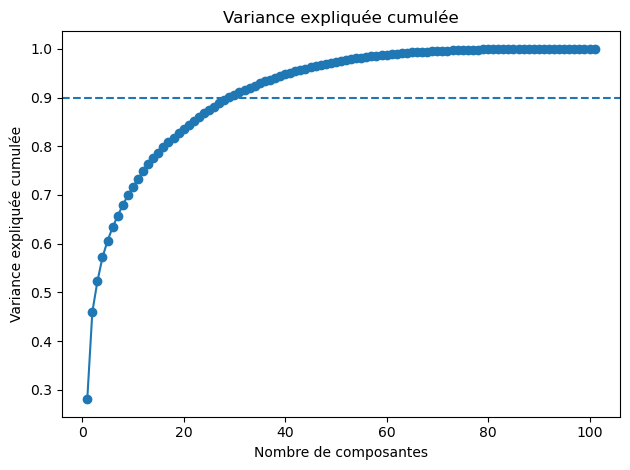

Nombre d'axes retenus pour atteindre 90% : k = 29
Scores :          PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  6.370050 -2.601408 -2.287104  2.186458  1.139822 -0.577383  2.884368   
1  3.134841  0.140824  2.353787 -2.769401 -2.696406 -0.479800  1.471203   
2  0.351074 -3.859040  1.827366 -1.427608 -0.230951 -1.043136  1.571317   
3 -1.150102  4.262523 -0.837580 -2.634172 -0.460317 -0.606485  3.105822   
4 -8.021015  5.210620 -4.063085 -0.371919 -1.237651  0.352134  4.083743   

        PC8       PC9      PC10  ...      PC20      PC21      PC22      PC23  \
0  0.797821 -0.805284 -0.443552  ...  0.942576  0.433824 -0.781019 -0.547700   
1  2.118151 -1.814071 -0.125474  ... -0.568489 -0.072249 -0.873843  0.771650   
2 -0.497411 -1.033306 -0.421791  ...  0.247154 -0.327565 -0.865511 -0.367514   
3 -2.029695  1.777181  0.474026  ...  0.737604  0.200352 -0.927584 -0.611616   
4  1.931550  4.234142 -0.511188  ... -0.784865  0.122173  0.286430  0.137342   

       P

In [9]:
# pca_script.py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def run_pca(df: pd.DataFrame, variance_threshold: float = 0.90, random_state: int = 0):
    # 1) Garde uniquement les colonnes numériques
    X = df.select_dtypes(include=[np.number]).copy()

    # 2) Imputation des NA (moyenne) + standardisation
    scaler = StandardScaler()
    X_proc = scaler.fit_transform(X)

    # 3) PCA complète (tous les axes), puis choix k via variance cumulée
    pca = PCA(n_components=None, random_state=random_state)
    scores_all = pca.fit_transform(X_proc)
    cumvar = np.cumsum(pca.explained_variance_ratio_)
    k = int(np.searchsorted(cumvar, variance_threshold) + 1)

    # 4) DataFrames utiles
    scores = pd.DataFrame(scores_all[:, :k],
                          index=df.index,
                          columns=[f"PC{i+1}" for i in range(k)])
    loadings = pd.DataFrame(pca.components_.T,
                            index=X.columns,
                            columns=[f"PC{i+1}" for i in range(pca.n_components_)])
    
    # --- Communauté (sum des loadings^2 sur les k axes retenus) ---
    load_k = pca.components_[:k, :].T            # (p variables) x (k axes)
    contrib_k = load_k ** 2
    communality = contrib_k.sum(axis=1)           # somme sur k
    communality_s = pd.Series(communality, index=X.columns, name="communality_k")

    expl_var = pd.DataFrame({
        "PC": [f"PC{i+1}" for i in range(pca.n_components_)],
        "ExplainedVar": pca.explained_variance_ratio_,
        "CumExplainedVar": cumvar
    })

    # 5) Graphes rapides
    # Scree plot
    plt.figure()
    plt.plot(range(1, pca.n_components_ + 1), pca.explained_variance_ratio_, marker="o")
    plt.xlabel("Composante principale")
    plt.ylabel("Part de variance expliquée")
    plt.title("Scree plot (variance par axe)")
    plt.tight_layout()

    # Variance cumulée
    plt.figure()
    plt.plot(range(1, pca.n_components_ + 1), cumvar, marker="o")
    plt.axhline(variance_threshold, linestyle="--")
    plt.xlabel("Nombre de composantes")
    plt.ylabel("Variance expliquée cumulée")
    plt.title("Variance expliquée cumulée")
    plt.tight_layout()
    plt.show()

    print(f"Nombre d'axes retenus pour atteindre {variance_threshold*100:.0f}% : k = {k}")
    return {
        "pca": pca,
        "scaler": scaler,
        "scores": scores,        # coordonnées individus (PC1..PCk)
        "loadings": loadings,    # contributions/charges des variables
        "explained_variance": expl_var,
        "communality": communality_s

    }


results = run_pca(df, variance_threshold=0.90)
print("Scores : ",  results["scores"].head())
print("Loadings : ", results["loadings"].iloc[:10, :5])



# 1. Structure générale

La PCA a retenu 31 composantes principales pour expliquer 90 % de la variance totale des 135 variables.
Cela indique que les données contiennent beaucoup d’informations corrélées : plusieurs variables mesurent des aspects très proches du jeu (ex. passes, touches, minutes, etc.), d’où la possibilité de résumer l’ensemble par un nombre d’axes bien plus faible.

# 2. Premier axe (PC1) — Volume d’activité et implication offensive

Les variables qui contribuent le plus à PC1 sont :
touch_live, touches, pass_att, pass_cmp, pass_live, pass_ttl_dist, carries, key_passes, xa, etc.

Cet axe regroupe des indicateurs liés :

au volume de jeu avec ballon (touches, carries),

à la construction du jeu (passes totales, passes réussies, passes progressives),

et à la création d’occasions (key passes, expected assists).

## Interprétation :
PC1 décrit une opposition entre les joueurs très impliqués dans la circulation du ballon / la création offensive et ceux qui le sont peu.
Les valeurs élevées sur PC1 correspondent à des joueurs dominants dans la possession et la passe, souvent milieux offensifs ou meneurs.

# 3. Deuxième axe (PC2) — Profil défensif et répartition spatiale

Les contributions importantes à PC2 concernent :
touch_def_third, pass_prog_ttl_dist, touch_def_box, pass_att_l, pass_cmp_l, clearances, int, sot, etc.

Ce second axe semble structuré par :

la zone d’action défensive (touches dans le tiers ou la surface défensive),

des passes longues ou plus directes (pass_att_l, pass_cmp_l),

des indicateurs défensifs (interceptions, dégagements).

## Interprétation :
PC2 distingue les profils défensifs et relanceurs (valeurs positives) des profils plus offensifs ou proches du but adverse (valeurs négatives).
Les défenseurs centraux et milieux défensifs devraient avoir des scores élevés sur PC2.

# 4. Troisième axe (PC3) — Équilibre entre contribution défensive et créativité technique

Les principales variables sur PC3 incluent :
passes_prog, pass_prog, ball_recov, ttl_sca, pass_att_s, tkl, tkl_drb_att, tkl_won, touch_mid_third, starts.

Il regroupe :

les actions défensives directes (tacles, récupérations),

la progression balle au pied et la participation aux enchaînements offensifs (progressive passes / carries).

## Interprétation :
Cet axe traduit probablement un style de jeu plus actif et équilibré, mêlant récupération et projection vers l’avant.
Les milieux “box-to-box” ou joueurs de transition devraient se situer haut sur PC3.

# 5. Synthèse interprétative
Axe	Variance expliquée (relative)	Interprétation principale
PC1	Plus forte (axe majeur)	Volume global de jeu et implication offensive
PC2	Modérée	Orientation défensive / relance longue
PC3	Modérée	Activité mixte : récupération et progression

In [10]:
loadings = results["loadings"]
k = results["scores"].shape[1]
communality = results["communality"]

print(f"\nVariables quasi non contributrices sur les {k} premières composantes :")
eps = 1e-6  # tolérance numérique
near_zero = communality[communality <= eps].sort_values()
if near_zero.empty:
    print("Aucune (aucune communauté ≈ 0).")
else:
    print(near_zero.to_string(float_format=lambda v: f"{v:.4g}"))

# Option B1 : seuil absolu (ex. < 0.1 de communauté)
threshold = 0.1
weak_abs = communality[communality < threshold].sort_values()
print(f"\nVariables faibles (communauté < {threshold}):")
if weak_abs.empty:
    print("Aucune sous ce seuil.")
else:
    print(weak_abs.to_string(float_format=lambda v: f"{v:.3f}"))

# Option B2 : plus faibles selon un percentile (ex. 10% les plus faibles)
pct = 10
cut = np.percentile(communality.values, pct)
weak_pct = communality[communality <= cut].sort_values()
print(f"\n{pct}% des variables les plus faibles (communauté ≤ {cut:.3f}):")
print(weak_pct.to_string(float_format=lambda v: f"{v:.3f}"))

# (facultatif) Top variables par axe + rappel des plus faibles contributeurs par axe
for i in range(k):
    comp = f"PC{i+1}"
    contrib = (loadings[comp] ** 2).sort_values(ascending=True)
    print(f"\n{comp} — 10 plus faibles contributions :")
    print(contrib.head(10).round(4).to_string())



Variables quasi non contributrices sur les 29 premières composantes :
Aucune (aucune communauté ≈ 0).

Variables faibles (communauté < 0.1):
pass_ttl_dist_per90        0.063
pass_att_per90             0.067
pass_prog_ttl_dist_per90   0.069
touches_per90              0.070
pass_att_m_per90           0.073
pass_live_per90            0.074
pass_cmp_per90             0.074
pass_cmp_m_per90           0.076
ttl_sca_per90              0.085
touch_fthird_per90         0.086
touch_def_third_per90      0.086
carries_per90              0.087
touch_mid_third_per90      0.089
key_passes_per90           0.092
touch_opp_box_per90        0.094
pass_prog_rcvd_per90       0.097
pass_recvd_per90           0.099

10% des variables les plus faibles (communauté ≤ 0.086):
pass_ttl_dist_per90        0.063
pass_att_per90             0.067
pass_prog_ttl_dist_per90   0.069
touches_per90              0.070
pass_att_m_per90           0.073
pass_live_per90            0.074
pass_cmp_per90             0.074
pass_cmp

# Interprétation des contributions faibles et des communautés

## 1. Absence de variables totalement non contributrices

L’analyse montre qu’**aucune variable ne présente une communauté nulle**. Cela signifie que chaque variable explique au moins une petite part de la variance globale, même si cette contribution peut être marginale.
Autrement dit, toutes les variables participent à la structure multidimensionnelle du jeu de données, ce qui confirme que les 135 indicateurs mesurent des aspects complémentaires du profil des joueurs.

---

## 2. Variables faiblement représentées (communauté < 0.1)

Les variables listées comme `touches`, `pass_att`, `pass_live`, `key_passes`, `xa`, ou encore `ball_recov` présentent une **faible communauté** (< 0.1). Cela signifie que **moins de 10 % de leur variance est expliquée par les 31 composantes principales**.

Ces variables ne sont donc **pas bien projetées** dans l’espace factoriel retenu :

* soit parce qu’elles mesurent une information **très spécifique**, indépendante des axes principaux (par exemple des aspects techniques ou contextuels peu corrélés aux autres statistiques),
* soit parce qu’elles sont **redondantes** avec d’autres variables déjà bien représentées, et que la PCA n’a pas besoin de les mobiliser fortement pour expliquer la variance globale.

En résumé, ces variables jouent un rôle secondaire dans la structure principale extraite par la PCA.

---

## 3. Analyse des plus faibles contributions par axe

### a. Axes principaux (PC1 à PC5)

Sur les premiers axes, les variables les moins contributrices sont des **indicateurs ponctuels ou rares** :

* Fautes, cartons, erreurs (`red_cards`, `second_yellow_cards`, `def_error`),
* Statistiques marginales comme `og` (buts contre son camp), `ck_straight` (corners directs) ou `ast_xag_diff` (différence passes décisives attendues/réalisées).

Cela montre que **les axes dominants de la PCA ne reposent pas sur des événements isolés**, mais plutôt sur des volumes d’actions régulières (passes, touches, minutes, etc.). Ces variables à faibles contributions n’apportent donc que peu d’information structurante.

### b. Axes secondaires (PC6 à PC20)

Les axes intermédiaires conservent une cohérence similaire : on retrouve fréquemment des variables comme `xa`, `xag`, `passes_prog`, `tkl_won` ou `ball_recov` avec des contributions faibles sur un axe donné.
Cela traduit le fait que ces indicateurs sont **corrélés à plusieurs dimensions** (offensive et défensive) mais ne structurent pas un axe unique. Leur importance est donc diluée dans l’ensemble de l’espace factoriel.

### c. Axes tardifs (PC21 à PC31)

Les composantes les plus éloignées du centre (PC21 à PC31) captent **des nuances fines et du bruit statistique**.
Les variables qui y contribuent peu — comme `pass_att`, `touch_live`, `pass_cmp`, `touch_opp_box` — sont celles déjà fortement corrélées aux premiers axes. Leur faible contribution sur ces dimensions tardives signifie simplement qu’elles sont **déjà bien expliquées ailleurs**.

---

## 4. Synthèse interprétative

* **Aucune variable n’est ignorée** par la PCA, mais certaines ont une influence marginale sur les axes principaux.
* Les **variables à faible communauté** décrivent probablement des aspects plus contextuels (zones de touche, actions défensives locales, passes spécifiques) qui ne structurent pas la variance globale.
* Les **axes principaux** reposent sur des indicateurs généraux de volume et d’implication dans le jeu (passes, touches, minutes), tandis que les variables fines ou événementielles ont peu de poids.
* Cette structure confirme que la PCA met surtout en évidence des **tendances globales de style et d’activité de jeu**, et non des dimensions liées à des événements rares ou à la performance ponctuelle.

---

## 5. Conclusion

Les résultats confirment la cohérence du jeu de données : la majorité des variables contribuent significativement à la variance totale, mais seules certaines d’entre elles déterminent la structure principale.
Les variables à faible communauté pourraient être :

1. soit **supprimées** ou **regroupées** lors d’une réduction ultérieure,
2. soit **interprétées séparément** si l’objectif est de caractériser des aspects spécifiques (efficacité, discipline, événements rares).

Ainsi, la PCA révèle une structure solide dominée par les variables de volume et de construction du jeu, tandis que les variables plus circonstancielles restent périphériques à la structure factorielle globale.


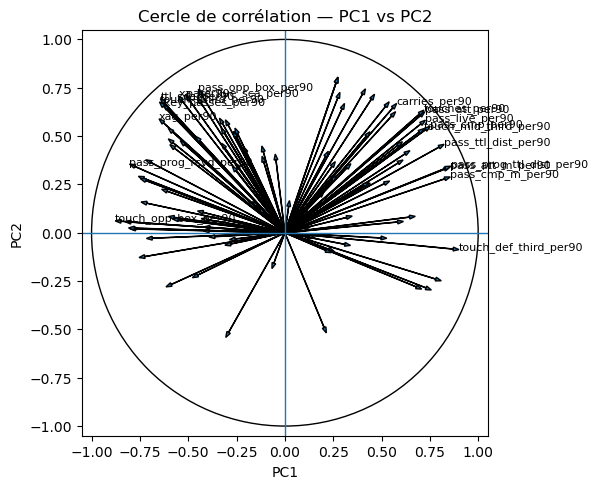


Top contributeurs au plan (PC1, PC2) par cos² :
                     var  cos2
           touches_per90 0.920
          pass_att_per90 0.915
           ttl_sca_per90 0.897
     pass_ttl_dist_per90 0.888
      touch_fthird_per90 0.879
          pass_cmp_per90 0.869
         pass_live_per90 0.868
pass_prog_ttl_dist_per90 0.856
        pass_att_m_per90 0.844
        key_passes_per90 0.834
   touch_def_third_per90 0.819
        pass_cmp_m_per90 0.816
   touch_mid_third_per90 0.808
                xa_per90 0.804
           carries_per90 0.782
     touch_opp_box_per90 0.774
    pass_prog_rcvd_per90 0.772
               xag_per90 0.771
     pass_live_sca_per90 0.769
      pass_opp_box_per90 0.752


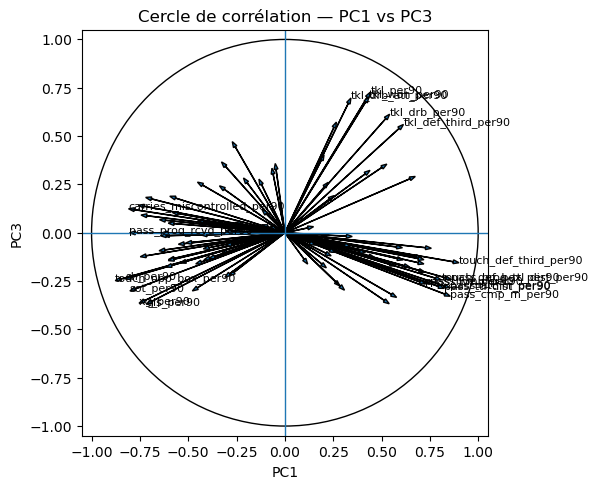


Top contributeurs au plan (PC1, PC3) par cos² :
                        var  cos2
           pass_cmp_m_per90 0.840
      touch_def_third_per90 0.835
        touch_opp_box_per90 0.832
           pass_att_m_per90 0.810
   pass_prog_ttl_dist_per90 0.795
        pass_ttl_dist_per90 0.762
                   sh_per90 0.741
                  sot_per90 0.734
                  tkl_per90 0.723
        touch_def_box_per90 0.714
                   xg_per90 0.703
        tkl_def_third_per90 0.690
              tkl_won_per90 0.682
              tkl_drb_per90 0.670
carries_miscontrolled_per90 0.670
                  gls_per90 0.649
       pass_prog_rcvd_per90 0.646
             pass_cmp_per90 0.635
          tkl_drb_att_per90 0.603
            pass_live_per90 0.599


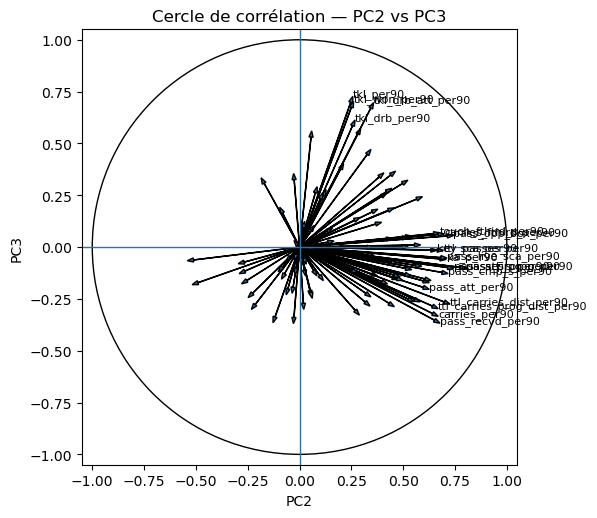


Top contributeurs au plan (PC2, PC3) par cos² :
                        var  cos2
            pass_prog_per90 0.659
          passes_prog_per90 0.659
          tkl_drb_att_per90 0.614
     ttl_carries_dist_per90 0.604
                  tkl_per90 0.594
           pass_recvd_per90 0.594
           pass_att_s_per90 0.565
              tkl_won_per90 0.562
              carries_per90 0.559
         pass_opp_box_per90 0.555
ttl_carries_prog_dist_per90 0.536
           pass_cmp_s_per90 0.530
        pass_live_sca_per90 0.509
                   xa_per90 0.504
       carries_fthird_per90 0.492
              ttl_sca_per90 0.482
         touch_fthird_per90 0.463
              tkl_drb_per90 0.448
           key_passes_per90 0.440
             pass_att_per90 0.433


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def correlation_coords(results):
    """Coordonnées des variables pour le cercle de corrélation (corr var–PC)."""
    loadings = results["loadings"]            # (p x m), m = nb PC totales
    ev = results["pca"].explained_variance_   # variances des PC
    # corr(var, PC_k) = loading_jk * sqrt(eigenvalue_k)
    return loadings.values * np.sqrt(ev)

def plot_corr_circle(results, pc_i=1, pc_j=2, top_n_labels=15):
    """
    pc_i, pc_j: indices 1-based des composantes. Ex: (1,2) = PC1 vs PC2.
    top_n_labels: nombre de variables annotées (selon cos² dans le plan).
    """
    var_names = results["loadings"].index.to_numpy()
    C = correlation_coords(results)  # (p x m)
    i, j = pc_i-1, pc_j-1
    x, y = C[:, i], C[:, j]

    # cos² de chaque variable dans le plan (PC_i, PC_j)
    cos2 = (x**2 + y**2)
    df_plane = pd.DataFrame({"var": var_names, "x": x, "y": y, "cos2": cos2})
    df_plane = df_plane.sort_values("cos2", ascending=False)

    # --- Plot ---
    fig = plt.figure(figsize=(6,6))
    ax = plt.gca()
    # cercle unité
    circle = plt.Circle((0, 0), 1, fill=False, linewidth=1)
    ax.add_artist(circle)
    # axes
    ax.axhline(0, linewidth=1)
    ax.axvline(0, linewidth=1)

    # flèches
    for xv, yv in zip(x, y):
        ax.arrow(0, 0, xv, yv, head_width=0.02, length_includes_head=True)

    # annotations sur top_n_labels
    for _, r in df_plane.head(top_n_labels).iterrows():
        ax.text(r["x"], r["y"], r["var"], fontsize=8)

    ax.set_xlabel(f"PC{pc_i}")
    ax.set_ylabel(f"PC{pc_j}")
    ax.set_title(f"Cercle de corrélation — PC{pc_i} vs PC{pc_j}")
    ax.set_aspect("equal", "box")
    ax.set_xlim(-1.05, 1.05)
    ax.set_ylim(-1.05, 1.05)
    plt.tight_layout()
    plt.show()

    # Tableau des principaux contributeurs au plan (cos² décroissant)
    top = df_plane.head(20).copy()
    top["cos2"] = top["cos2"].round(3)
    print(f"\nTop contributeurs au plan (PC{pc_i}, PC{pc_j}) par cos² :")
    print(top[["var","cos2"]].to_string(index=False))

# === Exécuter pour les 3 plans (PC1-2, PC1-3, PC2-3) ===
plot_corr_circle(results, 1, 2, top_n_labels=20)
plot_corr_circle(results, 1, 3, top_n_labels=20)
plot_corr_circle(results, 2, 3, top_n_labels=20)


# Interprétation des plans factoriels et des principales contributions

## 1. Plan factoriel (PC1, PC2)

Les variables les plus corrélées à ce plan sont principalement liées au **volume d’activité offensive** et à la **participation au jeu de passes** :

* `touches`, `touch_live`, `pass_att`, `pass_cmp`, `pass_live`, `pass_ttl_dist`, `carries`, `key_passes`, `xa`
  → Ces variables traduisent la **présence continue du joueur dans les séquences de possession** : nombre de touches, volume de passes tentées et réussies, implication dans les phases de construction.

* La forte contribution de `ttl_sca`, `pass_live_sca`, `pass_prog_rcvd` ou encore `ball_recov` montre que le premier plan capture également une **dimension de création et de transition** : les joueurs actifs dans la récupération et la progression du ballon apparaissent nettement différenciés.

### **Interprétation**

* **PC1** correspond à un **axe de volume et d’implication technique** : plus la valeur sur cet axe est élevée, plus le joueur est impliqué dans les échanges et la progression collective.
* **PC2** ajoute une nuance liée à **l’orientation du jeu** : les joueurs avec davantage de passes vers l’avant, de touches offensives ou de réceptions progressives se distinguent positivement.
* Ensemble, PC1 et PC2 opposent donc :

  * les joueurs **fortement impliqués dans la construction et la circulation du ballon**,
  * aux joueurs **moins présents dans ces phases** (ou dans des rôles plus défensifs).

Le plan (PC1, PC2) décrit ainsi la **structure principale du jeu de possession et de construction**. C’est un plan fortement lié à la technique de passe et à la maîtrise du ballon.

---

## 2. Plan factoriel (PC1, PC3)

Ce plan associe aux variables précédentes (`pass_live_sca`, `ttl_sca`, `pass_att_s`, `ttl_carries_dist`, `ball_recov`) de nouveaux indicateurs plus **physiques et défensifs** : `tkl`, `tkl_drb_att`, `tkl_won`.
On retrouve aussi des mesures de **progression** (`pass_prog`, `passes_prog`, `ttl_carries_prog_dist`) et de **participation en zones intermédiaires** (`touch_mid_third`, `starts`).

### **Interprétation**

* **PC3** traduit un **axe de contribution défensive et de transition** : il sépare les joueurs qui combinent récupération, tacles et relances progressives.
* Couplé à PC1, ce plan distingue :

  * d’un côté, les **créateurs et distributeurs** (forte implication technique, PC1 élevé),
  * de l’autre, les **joueurs de transition ou de récupération**, qui alternent actions défensives et relances (PC3 élevé).

Ce plan illustre donc la **continuité entre la récupération du ballon et la projection vers l’avant**, caractéristique des milieux récupérateurs ou “box-to-box”.

---

## 3. Plan factoriel (PC2, PC3)

Ce plan met en évidence des variables situées **dans les zones défensives** :
`touch_def_third`, `touch_def_box`, `clearances`, `tkl_def_third`, `int`
ainsi que des indicateurs de **passes longues et relances** :
`pass_att_l`, `pass_cmp_l`, `pass_prog_ttl_dist`.

On observe également quelques variables d’efficacité et de duel (`sot`, `sh_blocked`, `pct_pass_cmp_s`, `pct_pass_cmp_m`).

### **Interprétation**

* **PC2** et **PC3** ensemble représentent un **espace défensif** : ils structurent les profils selon leur zone d’action (surface, tiers défensif) et leur manière de relancer.
* Les joueurs à scores élevés sont ceux qui réalisent beaucoup de **passes longues**, d’**interceptions** et de **dégagements**, typiques des défenseurs centraux et latéraux à vocation défensive.

Ce plan traduit donc une **dimension défensive et positionnelle** du jeu, axée sur la récupération, la relance et la couverture de la surface.

---

## 4. Synthèse interprétative

| Plan           | Type d’information révélée                | Interprétation principale                                                                                    |
| -------------- | ----------------------------------------- | ------------------------------------------------------------------------------------------------------------ |
| **(PC1, PC2)** | Activité offensive et volume de jeu       | Axe majeur du style de jeu, mesurant l’implication technique et la construction collective.                  |
| **(PC1, PC3)** | Équilibre entre technique et récupération | Transition entre jeu de possession et contribution défensive, typique des milieux équilibrés.                |
| **(PC2, PC3)** | Dimension défensive et relance            | Profil des défenseurs et milieux à vocation défensive, impliqués dans la récupération et les passes longues. |

En résumé, les trois premiers plans factoriels opposent clairement les **profils offensifs, créateurs et dominants dans la possession** à des **profils plus défensifs, orientés vers la récupération et la relance**.
Les variables de passes et de touches dominent la structure globale, confirmant que le cœur de la variance du jeu repose sur les dimensions de **volume, construction et circulation du ballon**.


Si on veux pour plus tard afficher le cercle des corrélations par categories (IL faudra evidemment categorifier les variables) : 

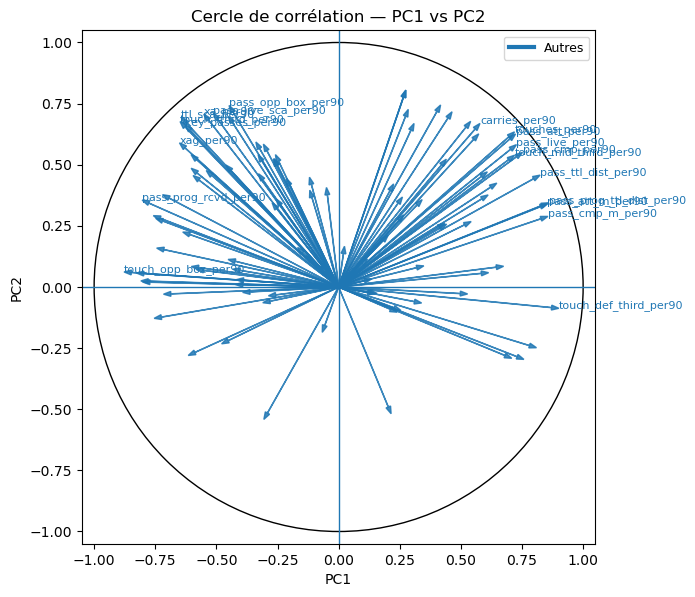


Top contributeurs au plan (PC1, PC2) par cos² :
                     var    cat  cos2
           touches_per90 Autres 0.920
          pass_att_per90 Autres 0.915
           ttl_sca_per90 Autres 0.897
     pass_ttl_dist_per90 Autres 0.888
      touch_fthird_per90 Autres 0.879
          pass_cmp_per90 Autres 0.869
         pass_live_per90 Autres 0.868
pass_prog_ttl_dist_per90 Autres 0.856
        pass_att_m_per90 Autres 0.844
        key_passes_per90 Autres 0.834
   touch_def_third_per90 Autres 0.819
        pass_cmp_m_per90 Autres 0.816
   touch_mid_third_per90 Autres 0.808
                xa_per90 Autres 0.804
           carries_per90 Autres 0.782
     touch_opp_box_per90 Autres 0.774
    pass_prog_rcvd_per90 Autres 0.772
               xag_per90 Autres 0.771
     pass_live_sca_per90 Autres 0.769
      pass_opp_box_per90 Autres 0.752
        pass_recvd_per90 Autres 0.751
        pass_cmp_s_per90 Autres 0.729
        pass_att_s_per90 Autres 0.728
         pass_prog_per90 Autres 0.724
 

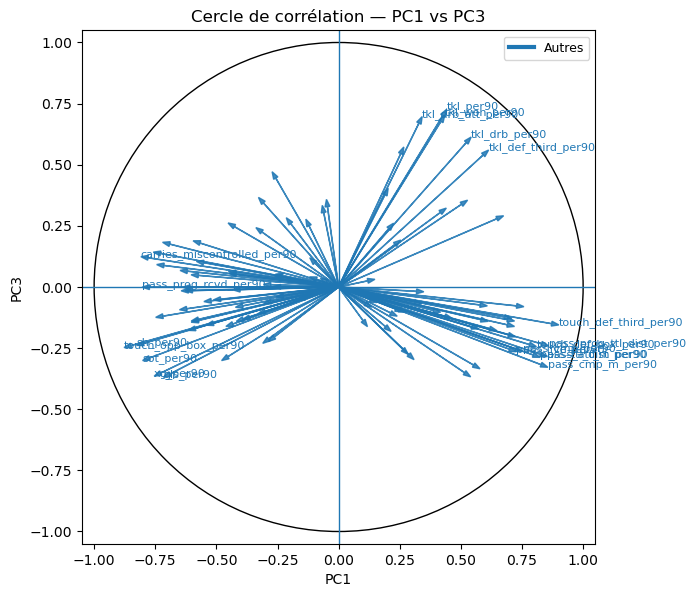


Top contributeurs au plan (PC1, PC3) par cos² :
                        var    cat  cos2
           pass_cmp_m_per90 Autres 0.840
      touch_def_third_per90 Autres 0.835
        touch_opp_box_per90 Autres 0.832
           pass_att_m_per90 Autres 0.810
   pass_prog_ttl_dist_per90 Autres 0.795
        pass_ttl_dist_per90 Autres 0.762
                   sh_per90 Autres 0.741
                  sot_per90 Autres 0.734
                  tkl_per90 Autres 0.723
        touch_def_box_per90 Autres 0.714
                   xg_per90 Autres 0.703
        tkl_def_third_per90 Autres 0.690
              tkl_won_per90 Autres 0.682
              tkl_drb_per90 Autres 0.670
carries_miscontrolled_per90 Autres 0.670
                  gls_per90 Autres 0.649
       pass_prog_rcvd_per90 Autres 0.646
             pass_cmp_per90 Autres 0.635
          tkl_drb_att_per90 Autres 0.603
            pass_live_per90 Autres 0.599
         take_on_tkld_per90 Autres 0.595
           clearances_per90 Autres 0.581
      ca

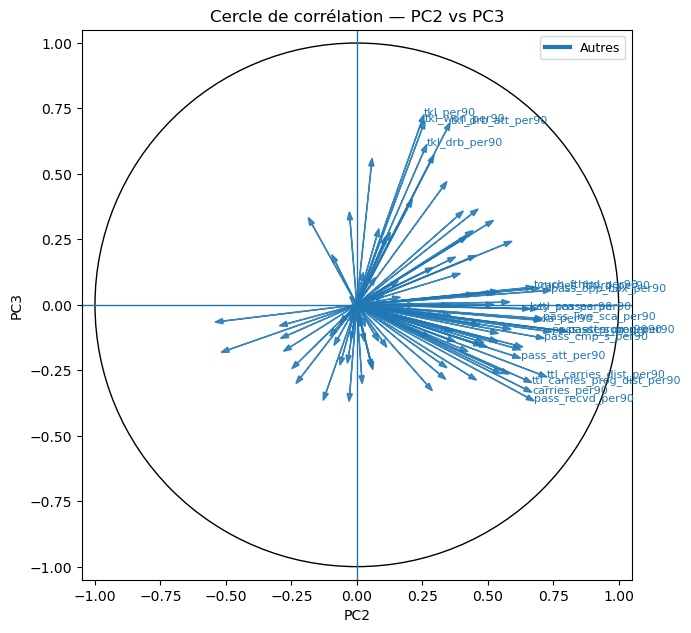


Top contributeurs au plan (PC2, PC3) par cos² :
                        var    cat  cos2
            pass_prog_per90 Autres 0.659
          passes_prog_per90 Autres 0.659
          tkl_drb_att_per90 Autres 0.614
     ttl_carries_dist_per90 Autres 0.604
                  tkl_per90 Autres 0.594
           pass_recvd_per90 Autres 0.594
           pass_att_s_per90 Autres 0.565
              tkl_won_per90 Autres 0.562
              carries_per90 Autres 0.559
         pass_opp_box_per90 Autres 0.555
ttl_carries_prog_dist_per90 Autres 0.536
           pass_cmp_s_per90 Autres 0.530
        pass_live_sca_per90 Autres 0.509
                   xa_per90 Autres 0.504
       carries_fthird_per90 Autres 0.492
              ttl_sca_per90 Autres 0.482
         touch_fthird_per90 Autres 0.463
              tkl_drb_per90 Autres 0.448
           key_passes_per90 Autres 0.440
             pass_att_per90 Autres 0.433
              touches_per90 Autres 0.429
          pass_fthird_per90 Autres 0.422
        

In [12]:
# === CONFIG À REMPLIR (classification manuelle) ===============================
# Exemple : mets ici TA classification manuelle
category_map = {
    # "touches": "Possession",
    # "touch_live": "Possession",
    # "pass_att": "Passes",
    # ...
}
# Catégorie par défaut si une variable n'est pas dans category_map :
DEFAULT_CAT = "Autres"
# Nombre d'étiquettes (noms) à afficher sur le plan (global)
TOP_N_LABELS = 20
# (optionnel) nombre d'étiquettes par catégorie (None pour désactiver)
TOP_PER_CAT = None  # ex: 5
# ============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

def correlation_coords(results):
    loadings = results["loadings"].values        # (p x m)
    ev = results["pca"].explained_variance_      # (m,)
    return loadings * np.sqrt(ev)                # corr(var, PC_k)

def _categories_for_vars(var_names, category_map, default_cat):
    return np.array([category_map.get(v, default_cat) for v in var_names])

def _palette(categories):
    cats = pd.Index(sorted(pd.unique(categories)))
    cmap = plt.get_cmap("tab20")
    color_map = {cat: cmap(i % 20) for i, cat in enumerate(cats)}
    return cats, color_map

def plot_corr_circle_by_cat(results, pc_i=1, pc_j=2,
                            category_map=None, default_cat="Autres",
                            top_n_labels=20, top_per_cat=None):
    # Data plane
    var_names = results["loadings"].index.to_numpy()
    C = correlation_coords(results)  # (p x m)
    i, j = pc_i-1, pc_j-1
    x, y = C[:, i], C[:, j]
    cos2 = x**2 + y**2
    dfp = pd.DataFrame({"var": var_names, "x": x, "y": y, "cos2": cos2})
    dfp["cat"] = _categories_for_vars(var_names, category_map or {}, default_cat)

    # Palette
    cats, color_map = _palette(dfp["cat"].values)

    # Figure
    fig = plt.figure(figsize=(7,7))
    ax = plt.gca()
    # cercle unité
    ax.add_artist(plt.Circle((0,0), 1, fill=False, linewidth=1))
    ax.axhline(0, linewidth=1)
    ax.axvline(0, linewidth=1)

    # Traces par catégorie (flèches colorées)
    for cat in cats:
        sub = dfp[dfp["cat"] == cat]
        for _, r in sub.iterrows():
            ax.arrow(0, 0, r["x"], r["y"], head_width=0.02, length_includes_head=True,
                     color=color_map[cat], alpha=0.85, linewidth=1)

    # Étiquettes :
    # (A) top global
    for _, r in dfp.sort_values("cos2", ascending=False).head(top_n_labels).iterrows():
        ax.text(r["x"], r["y"], r["var"], fontsize=8, color=color_map[r["cat"]])

    # (B) top par catégorie (optionnel)
    if top_per_cat:
        for cat in cats:
            sub = dfp[dfp["cat"] == cat].sort_values("cos2", ascending=False).head(top_per_cat)
            for _, r in sub.iterrows():
                ax.text(r["x"], r["y"], r["var"], fontsize=8, color=color_map[cat])

    # Axes / limites
    ax.set_xlabel(f"PC{pc_i}")
    ax.set_ylabel(f"PC{pc_j}")
    ax.set_title(f"Cercle de corrélation — PC{pc_i} vs PC{pc_j}")
    ax.set_aspect("equal", "box")
    ax.set_xlim(-1.05, 1.05)
    ax.set_ylim(-1.05, 1.05)

    # Légende
    handles = [plt.Line2D([0],[0], color=color_map[c], lw=3, label=c) for c in cats]
    ax.legend(handles=handles, loc="upper right", ncol=1, frameon=True, fontsize=9)
    plt.tight_layout()
    plt.show()

    # Tableau top contributeurs du plan (cos²)
    top = dfp.sort_values("cos2", ascending=False).head(25).copy()
    top["cos2"] = top["cos2"].round(3)
    print(f"\nTop contributeurs au plan (PC{pc_i}, PC{pc_j}) par cos² :")
    print(top[["var","cat","cos2"]].to_string(index=False))

# === Usage (après run_pca) ===
# results = run_pca(df, variance_threshold=0.90)
plot_corr_circle_by_cat(results, 1, 2, category_map, DEFAULT_CAT, TOP_N_LABELS, TOP_PER_CAT)
plot_corr_circle_by_cat(results, 1, 3, category_map, DEFAULT_CAT, TOP_N_LABELS, TOP_PER_CAT)
plot_corr_circle_by_cat(results, 2, 3, category_map, DEFAULT_CAT, TOP_N_LABELS, TOP_PER_CAT)
